# Ebro: catchment 628

This subcatchment is a very small catchment constrained upstream by station 607 and downstream by station 628. There is one reservoir (4137) just upstream from the outlet, whose inflow is mostly the streamflow in the upstream station 607, although there is a tributary on the South, even if its catchment area is smaller. 

***Table 1**. Reservoir ID in the Global Dam Watch (GDW), Global Reservoir and Dam (GRanD) database and EFAS.*

| GDW_ID | GRanD_ID | EFAS_ID |
| ------ | -------- | ------- |
| 4135 | 2757 | 9442 |

***Figure 1**. Scheme of the catchment including reservoirs (pink triangle) and gauging stations used for calibration (circles).*

<img src="./images/628.jpg" alt="Catchment scheme" width="800"/>

The reservoir 4135 is not in the ResOpsES (Reservoir Operations - España) dataset, so the reservoir parameters were estimated, not calibrated.

In [173]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

In [121]:
from reservoirs_lshm.calibration import read_results
from reservoirs_lshm.calibration.camaflood_calibrator import CamafloodCalibrator
from reservoirs_lshm.models import get_model
from reservoirs_lshm.models import Camaflood
from reservoirs_lshm.utils.metrics import KGEmod

In [113]:
import spotpy

## Configuration

In [96]:
path_efas = Path('Z:/nahaUsers/casadje/EFASv6/reservoirs/')
path_catchment = path_efas / 'tests' / 'Ebro'
path_obs = path / 'HYDRO' / 'timeseries'
path_resops = Path('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsES/v3.0')

### Reservoirs

In [8]:
# reservoirs in the catchment
reservoirs = {
    4135: {
        'GRAND_ID': 2757,
        'EFAS_ID': 9442
    }
}
reservoirs = pd.DataFrame.from_dict(reservoirs, orient='index').rename_axis('GDW_ID')

In [9]:
# import reservoirs in EFAS6
res_efas6 = gpd.read_file(
    path_efas / 'tables' / 'reservoirs_efas6_20250303.shp'
).set_index('GDW_ID')
res_efas6.GRAND_ID = res_efas6.GRAND_ID.astype('Int64')

# add calibrated/estimated parameters
for parname in ['flood_storage', 'outflow_factor']:
    series = pd.read_csv(
        path_efas / 'tables' / 'parameters' / f'reservoirs_efas6_{parname}.txt', 
        header=None,
        index_col=0,
        sep='\t'
    ).squeeze()
    series.index.name = 'GDW_ID',
    series.name = parname
    res_efas6 = pd.concat((res_efas6, series), axis=1)
res_efas6.index.name = 'GDW_ID'

print(f'{len(res_efas6)} reservoirs in total')

reservoirs = pd.concat([reservoirs, res_efas6], axis=1, join='inner')
print(f'{len(reservoirs)} reservoirs in the catchment')

1545 reservoirs in total
1 reservoirs in the catchment


In [80]:
# extract reservoir characteristics
cap_cm, catch_sm, area_sm = reservoirs.loc[gdw_id, ['CAP_MCM', 'CATCH_SKM', 'AREA_SKM']] * 1e6
# extract inflow characteristics
Qmin, Qn, Q100 = reservoirs.loc[gdw_id, ['DISENV_CMS', 'DISAVG_CMS', 'DIS100_CMS']]
# extract reservoir parameters
par_Vf, par_Qf = reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

## Observation

### Streamflow

#### Downstream

In [28]:
# observed streamflow in the gauging station
efas_id = 628
streamflow_ds = pd.read_csv(path_obs / f'{efas_id}.csv', index_col=0, parse_dates=True).squeeze()
streamflow_ds.name = efas_id

#### Upstream

In [29]:
# observed streamflow in the upstream gauging station
efas_id = 607
streamflow_us = pd.read_csv(path_obs / f'{efas_id}.csv', index_col=0, parse_dates=True).squeeze()
streamflow_us.name = efas_id

#### Merge

In [30]:
streamflow = pd.concat([streamflow_us, streamflow_ds], axis=1)
mask = streamflow.notnull().all(axis=1)
start, end = streamflow[mask].index[0], streamflow[mask].index[-1]
streamflow = streamflow.loc[start:end]

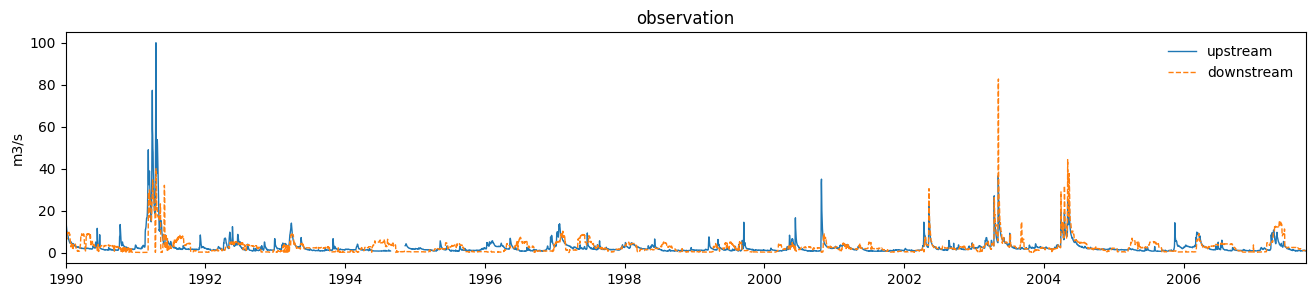

In [58]:
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(
    streamflow[607],
    lw=1,
    label='upstream'
)
ax.plot(
    streamflow[628],
    lw=1,
    ls='--',
    label='downstream'
)
ax.set(
    xlim=(start, end),
    ylabel='m3/s',
    title='observation'
)
ax.legend(frameon=False);

The data seems coherent.

### Release

#### ResOpsES

In [35]:
for gdw_id, row in reservoirs.iterrows():
    grand_id = row.GRAND_ID
    file = path_resops / 'time_series' / 'csv' / f'{grand_id}.csv'
    if file.is_file():
        resops = pd.read_csv(file, parse_dates=True, index_col=0, usecols=['date', 'outflow', 'storage'])
    else:
        print(f'{file} does not exist')

Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\v3.0\time_series\csv\GRAND_ID    2757
GRAND_ID    2757
Name: 4135, dtype: object.csv does not exist


#### HYDRO

In [88]:
for gdw_id, row in reservoirs.iterrows():
    efas_id = row.EFAS_ID
    file = path_obs / f'{efas_id}.csv'
    if file.is_file():
        hydro = pd.read_csv(file, index_col=0, parse_dates=True)
        # hydro.name = 'outflow'
    else:
        print(f'{file} does not exist')
# convert storage to hm3
hydro.storage *= 1e6
# create dummy inflow time series
hydro['inflow'] = np.nan

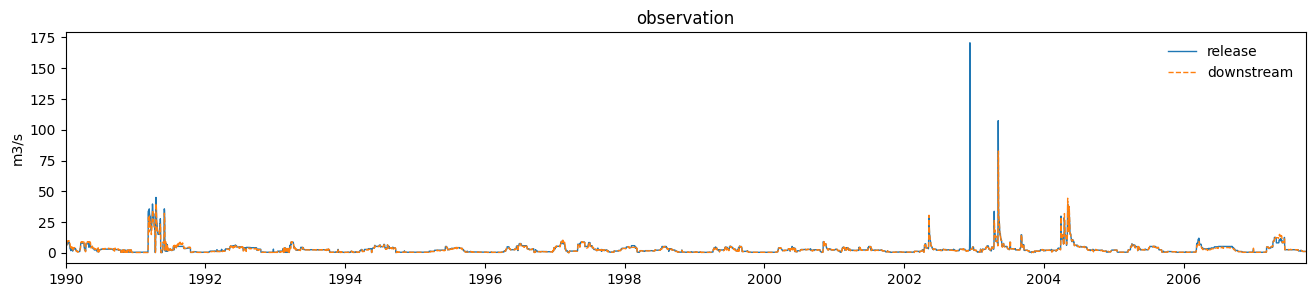

In [89]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(
    hydro['outflow'],
    lw=1,
    ls='-',
    label='release'
)
ax.plot(
    streamflow[628],
    lw=1,
    ls='--',
    label='downstream'
)
ax.set(
    xlim=(start, end),
    ylabel='m3/s',
    title='observation'
)
ax.legend(frameon=False);

The streamflow in the downstream station is basically the same as the reservoir release, besides the peak at the end of 2002.

### Simulated

In [66]:
sim_files = {
    'inflow': path / 'RES_inflow.csv',
    'outflow': path / 'RES_outflow.csv',
    'storage': path / 'RES_fill.csv'
}

gdw_id = reservoirs.index[0]

In [79]:
efas6 = pd.DataFrame(dtype=float)
for var, file in sim_files.items():
    # load simulated time series
    data = pd.read_csv(
        file, 
        parse_dates=True, 
        index_col=0
    )
    data.columns = data.columns.astype(int)
    data.index = pd.to_datetime(data.index, format='%d/%m/%Y %H:%M')

    if gdw_id in data.columns:
        serie = data[gdw_id]
        if var == 'storage':
            serie *= cap_cm #reservoirs.loc[gdw_id, 'CAP_MCM'] * 1e6
        efas6[var] = serie
    else:
        print(f'{gdw_id} was not found in the {var} simulated time series')        

In [83]:
# resample daily
efas6_d = efas6.groupby(efas6.index.floor('D')).mean()

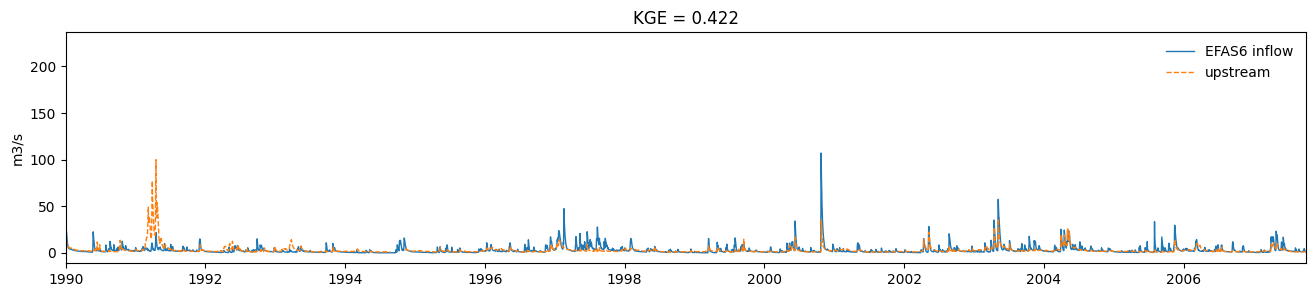

In [84]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(
    efas6_d['inflow'],
    lw=1,
    ls='-',
    label='EFAS6 inflow'
)
ax.plot(
    streamflow[607],
    lw=1,
    ls='--',
    label='upstream'
)
kge = KGEmod(obs=streamflow[607], sim=efas6_d['inflow'])[0]
ax.set(
    xlim=(start, end),
    ylabel='m3/s',
    title=f'KGE = {kge:.3f}'
)

ax.legend(frameon=False);

The analysis about simplifies the reservoir as it has two inflows, not just station 607. However, in terms of catchment area, station 607 approximately 80% of the catchment. The KGE of station 607 is 0.44, according to the data shared by Cinzia.

## Analysis

In [98]:
path_results = path_catchment / '628'
path_results.mkdir(parents=True, exist_ok=True)

### EFAS6 simulation

In [155]:
# define reservoir limits
Vf = par_Vf * cap_cm
Ve = cap_cm * (0.8 + 0.2 * par_Vf)
Vmin = 0.5 * Vf
Qf = Q100 * par_Qf
Qmin = 0.5 * Qn

# reservoir limits
Vlims = [Vmin, Vf, Ve, cap_cm]
Qlims = [Qmin, Qf, Qf, Qf]

In [156]:
# declare reservoir
res = Camaflood(
    Vmin=Vmin,
    Vf=Vf,
    Ve=Ve,
    Vtot=cap_cm,
    Qn=Qn,
    Qf=Qf,
    catchment=catch_sm,
    Atot=area_sm,
    timestep=6*3600
)

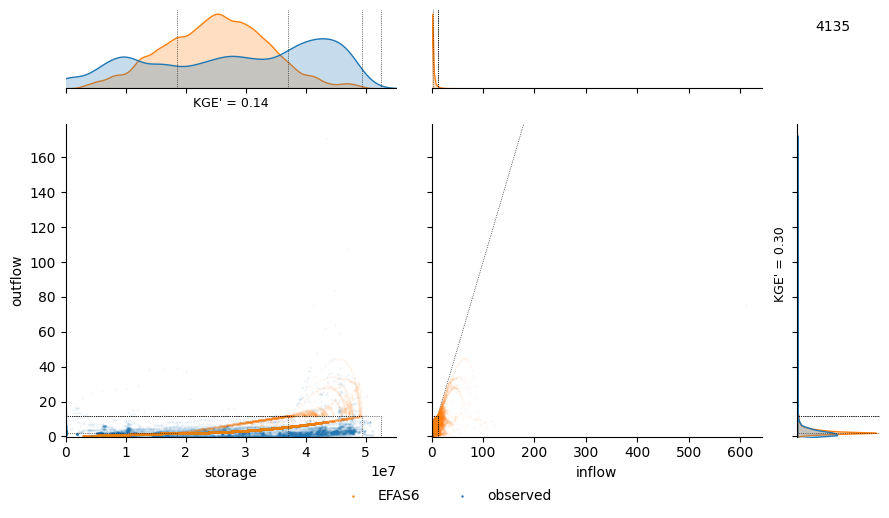

In [160]:
# compare LISFLOOD vs observation
res.scatter(
    efas6,
    hydro,
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['EFAS6', 'observed'],
    # save=path_results / f'{gdw_id}_scatter_efas6_vs_observed.jpg'
)

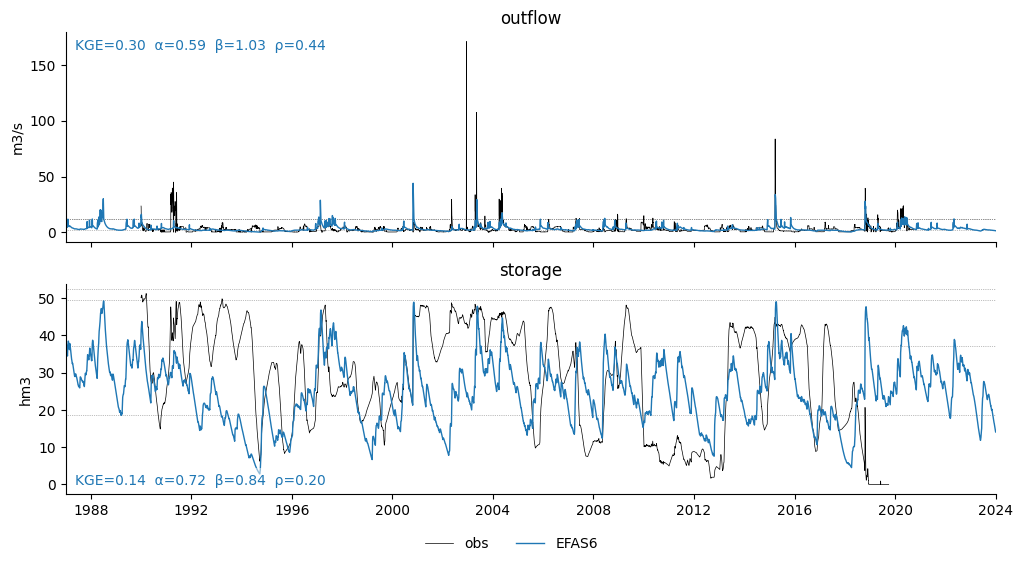

In [161]:
res.lineplot(
        sim={
            'EFAS6': efas6_d,
        },
        obs=hydro,
        Vlims=Vlims,
        Qlims=Qlims,
        # spinup=cfg.SPINUP,
        title=gdw_id,
        figsize=(12, 6),
        # save=path_results / f'{gdw_id}_line_efas6_vs_observed.jpg'
    )

### Simulate CaMa-Flood

In [159]:
sim = res.simulate(
    inflow=efas6.inflow,
    Vo=None,
)

timesteps:   0%|          | 0/54056 [00:00<?, ?it/s]

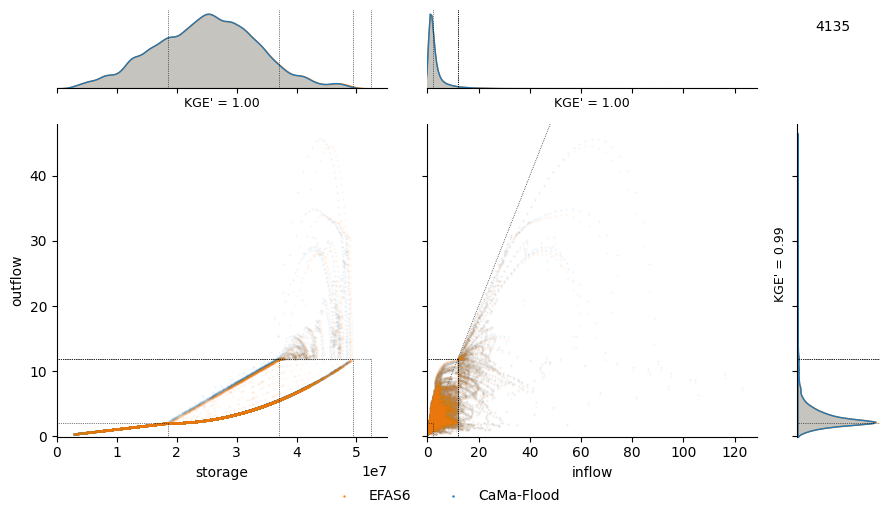

In [166]:
# compare EFAS6 vs CaMa-Flood
res.scatter(
    efas6,
    sim,
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['EFAS6', 'CaMa-Flood'],
    spinup=365,
    # save=path_results / f'{gdw_id}_scatter_efas6_vs_observed.jpg'
)

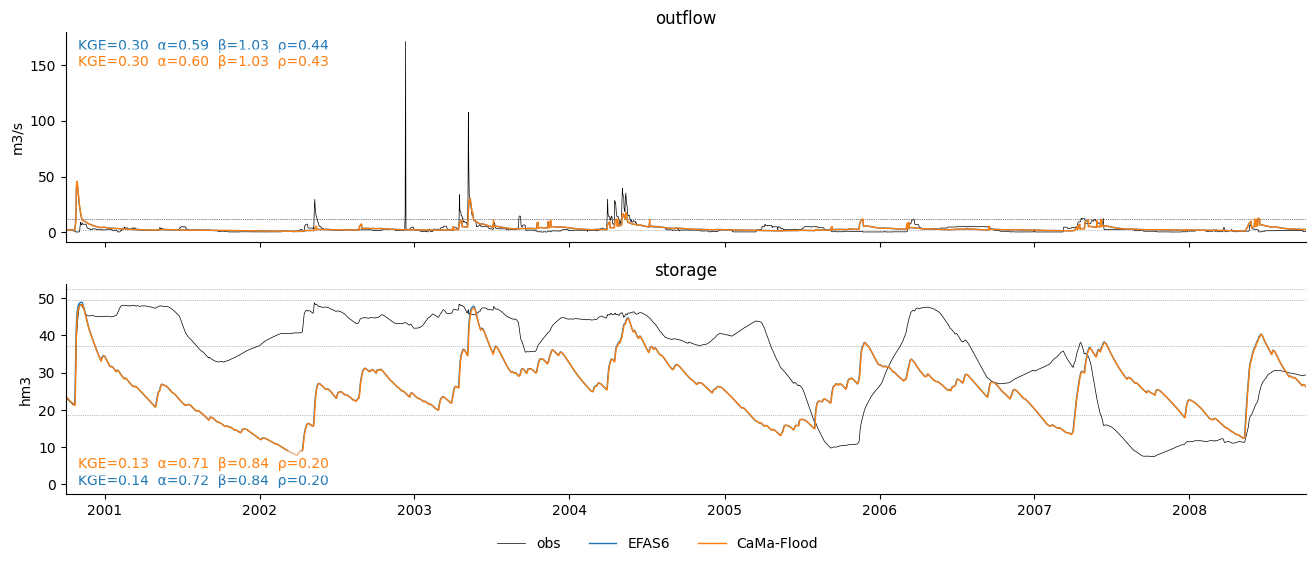

In [176]:
res.lineplot(
    sim={
        'EFAS6': efas6_d,
        'CaMa-Flood': sim,
    },
    obs=hydro,
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=365,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2000, 10, 1), datetime(2008, 10, 1))
    # save=path_results / f'{gdw_id}_line_efas6_vs_observed.jpg'
)

The plots above prove that the CaMa-Flood routine in OS-LISFLOOD behaves as expected (as the isolated routine in `lisflood-reservoirs`) at 6-hour time steps.

### Calibrate CaMa-Flood

In [141]:
parameters_cal = {
    'alpha': {
        'low': 0.2,
        'high': 0.99
    },
    'delta': {
        'low': 0.1,
        'high': 0.5
    },
}

target = ['storage', 'outflow']

In [142]:
# time series: simulated inflow, observed storage and outflow
cal_ts = pd.concat([efas6_d.inflow, hydro.storage, hydro.outflow], axis=1)
mask = cal_ts.notnull().all(axis=1)
start, end = cal_ts[mask].index[0], cal_ts[mask].index[-1]
cal_ts = cal_ts.loc[start:end]

In [143]:
# declare reservoir
calibrator = CamafloodCalibrator(
    parameters=parameters_cal,
    inflow=cal_ts.inflow,
    storage=cal_ts.storage,
    outflow=cal_ts.outflow,
    Vmin=max(0, min(0.1 * cap_cm, cal_ts.storage.min())),
    Vtot=cap_cm,
    catchment=catch_sm,
    # Atot=area_sm,
    target=target,
    obj_func=KGEmod,
    spinup=365,
)

# define the sampling method
dbname = f'{path_results}/{gdw_id}_samples'
sceua = spotpy.algorithms.sceua(
    calibrator, 
    dbname=dbname, 
    dbformat='csv', 
    save_sim=False,
)

# launch calibration
sceua.sample(
    5000, 
    ngs=4, 
    kstop=5, 
    pcento=0.001, 
    peps=0.01
)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  5000  repetitions
The objective function will be minimized
Starting burn-in sampling...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'Z:\nahaUsers\casadje\EFASv6\reservoirs\tests\Ebro\628/4135_samples.csv' created.


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

5 of 5000, minimal objective function=1.26365, time remaining: 00:27:47


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

11 of 5000, minimal objective function=1.22824, time remaining: 00:28:25


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

17 of 5000, minimal objective function=1.10696, time remaining: 00:28:42


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

28 of 5000, minimal objective function=1.10696, time remaining: 00:27:48


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

41 of 5000, minimal objective function=1.10696, time remaining: 00:25:04


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

53 of 5000, minimal objective function=1.09232, time remaining: 00:23:13


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

ComplexEvo loop #2 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

75 of 5000, minimal objective function=1.09232, time remaining: 00:21:04


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

88 of 5000, minimal objective function=1.09232, time remaining: 00:20:38


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

101 of 5000, minimal objective function=1.08995, time remaining: 00:20:28


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

ComplexEvo loop #3 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

125 of 5000, minimal objective function=1.08995, time remaining: 00:19:50


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

138 of 5000, minimal objective function=1.08995, time remaining: 00:19:34


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

151 of 5000, minimal objective function=1.08995, time remaining: 00:19:22


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

165 of 5000, minimal objective function=1.08995, time remaining: 00:19:18
ComplexEvo loop #4 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

179 of 5000, minimal objective function=1.08875, time remaining: 00:19:10


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

193 of 5000, minimal objective function=1.0886, time remaining: 00:19:02


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

206 of 5000, minimal objective function=1.0886, time remaining: 00:18:57


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

218 of 5000, minimal objective function=1.08829, time remaining: 00:18:51
ComplexEvo loop #5 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

233 of 5000, minimal objective function=1.08829, time remaining: 00:18:52


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

246 of 5000, minimal objective function=1.08829, time remaining: 00:18:45


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

259 of 5000, minimal objective function=1.08829, time remaining: 00:18:41


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

273 of 5000, minimal objective function=1.08752, time remaining: 00:18:35
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.440789
ComplexEvo loop #6 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

287 of 5000, minimal objective function=1.08752, time remaining: 00:18:31


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

301 of 5000, minimal objective function=1.08752, time remaining: 00:18:26


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

315 of 5000, minimal objective function=1.08731, time remaining: 00:18:24


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

329 of 5000, minimal objective function=1.08731, time remaining: 00:18:19
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.242171
ComplexEvo loop #7 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

343 of 5000, minimal objective function=1.08704, time remaining: 00:18:15


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

358 of 5000, minimal objective function=1.08704, time remaining: 00:18:12


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

371 of 5000, minimal objective function=1.08704, time remaining: 00:18:08


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

385 of 5000, minimal objective function=1.08704, time remaining: 00:18:05
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.267135
ComplexEvo loop #8 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

397 of 5000, minimal objective function=1.08704, time remaining: 00:17:59


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

410 of 5000, minimal objective function=1.08704, time remaining: 00:17:55


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

423 of 5000, minimal objective function=1.08704, time remaining: 00:17:52


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

437 of 5000, minimal objective function=1.08704, time remaining: 00:17:49
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.114693
ComplexEvo loop #9 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

452 of 5000, minimal objective function=1.08704, time remaining: 00:17:46


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

466 of 5000, minimal objective function=1.08704, time remaining: 00:17:43


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

479 of 5000, minimal objective function=1.08704, time remaining: 00:17:40


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

493 of 5000, minimal objective function=1.08704, time remaining: 00:17:37
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.044056
ComplexEvo loop #10 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

507 of 5000, minimal objective function=1.08704, time remaining: 00:17:33


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

521 of 5000, minimal objective function=1.08692, time remaining: 00:17:31


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

535 of 5000, minimal objective function=1.08692, time remaining: 00:17:27


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

548 of 5000, minimal objective function=1.08692, time remaining: 00:17:22
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.035916
ComplexEvo loop #11 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

563 of 5000, minimal objective function=1.08692, time remaining: 00:17:19


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

575 of 5000, minimal objective function=1.08692, time remaining: 00:17:15


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

589 of 5000, minimal objective function=1.08692, time remaining: 00:17:12


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

602 of 5000, minimal objective function=1.08692, time remaining: 00:17:07
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.011060
ComplexEvo loop #12 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

615 of 5000, minimal objective function=1.08692, time remaining: 00:17:03


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

628 of 5000, minimal objective function=1.08692, time remaining: 00:17:00


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

641 of 5000, minimal objective function=1.08692, time remaining: 00:16:56


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

653 of 5000, minimal objective function=1.08692, time remaining: 00:16:51
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.011061
ComplexEvo loop #13 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

667 of 5000, minimal objective function=1.08692, time remaining: 00:16:48


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

683 of 5000, minimal objective function=1.08692, time remaining: 00:16:46


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

697 of 5000, minimal objective function=1.08692, time remaining: 00:16:43


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

710 of 5000, minimal objective function=1.08692, time remaining: 00:16:39
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.010818
ComplexEvo loop #14 in progress...


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

726 of 5000, minimal objective function=1.08692, time remaining: 00:16:36


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

742 of 5000, minimal objective function=1.08692, time remaining: 00:16:35


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

756 of 5000, minimal objective function=1.08692, time remaining: 00:16:32


timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

767 of 5000, minimal objective function=1.08692, time remaining: 00:16:27
Objective function convergence criteria is now being updated and assessed...
Updated convergence criteria: 0.000388
THE BEST POINT HAS IMPROVED IN LAST 5 LOOPS BY LESS THAN THE USER-SPECIFIED THRESHOLD 0.001000
CONVERGENCY HAS ACHIEVED BASED ON OBJECTIVE FUNCTION CRITERIA!!!
SEARCH WAS STOPPED AT TRIAL NUMBER: 771
NUMBER OF DISCARDED TRIALS: 0
NORMALIZED GEOMETRIC RANGE = 0.762159
THE BEST POINT HAS IMPROVED IN LAST 5 LOOPS BY 0.000388 PERCENT

*** Final SPOTPY summary ***
Total Duration: 179.07 seconds
Total Repetitions: 771
Minimal objective value: 1.08692
Corresponding parameter setting:
alpha: 0.60113
delta: 0.102216
******************************



In [144]:
# read calibration results
iterations, optimal_parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(optimal_parameters.values()))

# declare the reservoir with optimal parameters
res = get_model('camaflood', **calibrated_attrs)

In [145]:
# simulate the reservoir
Vo = cal_ts.storage.iloc[0]
sim_cal = res.simulate(
    inflow=cal_ts.inflow,
    Vo=None if pd.isna(Vo) else Vo,
)

timesteps:   0%|          | 0/10865 [00:00<?, ?it/s]

e:\casadje\github\lisflood-reservoirs\src\reservoirs_lshm\models\camaflood.py:141: RuntimeWarning: overflow encountered in cast
  if V - Q * self.timestep > self.Vtot:
e:\casadje\github\lisflood-reservoirs\src\reservoirs_lshm\models\camaflood.py:145: RuntimeWarning: overflow encountered in cast
  elif V - Q * self.timestep < 0:


In [170]:
reservoirs.loc[gdw_id, ['flood_storage', 'outflow_factor']]

flood_storage     0.705868
outflow_factor    0.186326
Name: 4135, dtype: object

In [147]:
optimal_parameters

{'alpha': 0.60112983, 'delta': 0.10221568}

In [148]:
# define reservoir limits
Vf = optimal_parameters['alpha'] * cap_cm
Ve = cap_cm * (0.8 + 0.2 * optimal_parameters['delta'])
Vmin = 0.5 * Vf
Qf = Q100 * par_Qf
Qmin = 0.5 * Qn

# reservoir limits
Vlims = [Vmin, Vf, Ve, cap_cm]
Qlims = [Qmin, Qf, Qf, Qf]

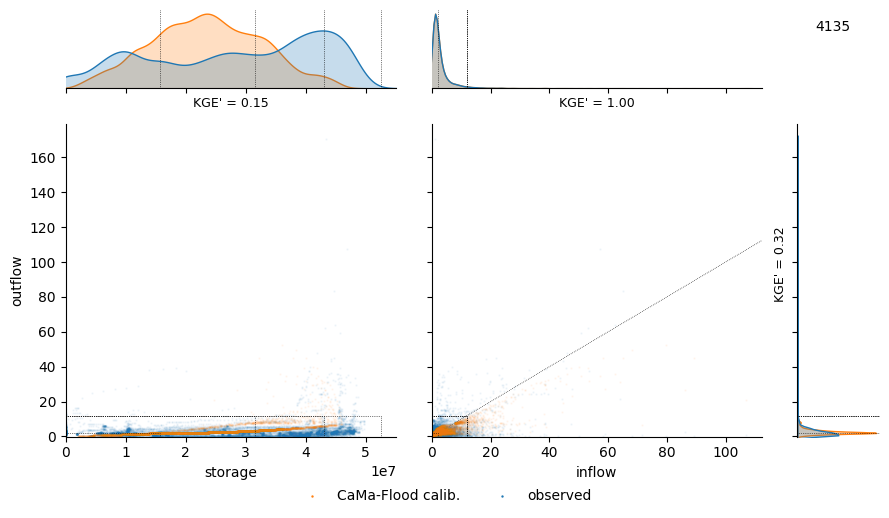

In [153]:
res.scatter(
    sim_cal.iloc[365:],
    cal_ts.iloc[365:],
    norm=False,
    title=gdw_id,
    Vlims=Vlims,
    Qlims=Qlims,
    labels=['CaMa-Flood calib.', 'observed'],
    # save=path_results / f'{gdw_id}_scatter_CaMa-Flood_vs_observed.jpg'
)

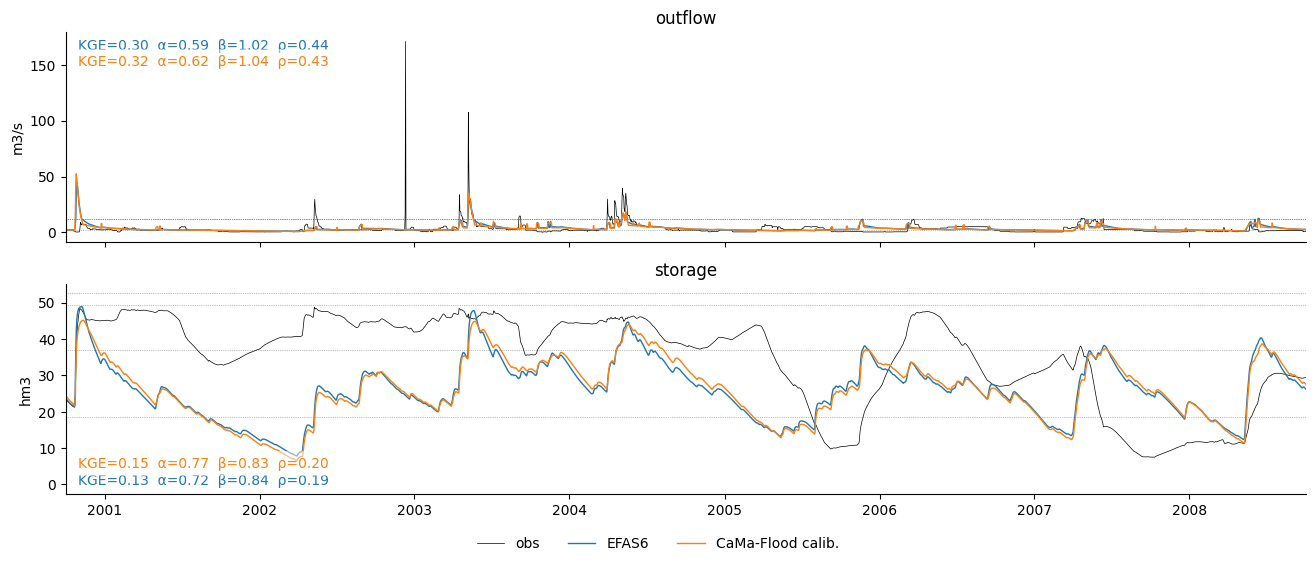

In [174]:
res.lineplot(
    sim={
        'EFAS6': efas6_d.iloc[365:],
        'CaMa-Flood calib.': sim_cal.iloc[365:],
    },
    obs=hydro.iloc[365:],
    Vlims=Vlims,
    Qlims=Qlims,
    # spinup=cfg.SPINUP,
    title=gdw_id,
    figsize=(16, 6),
    xlim=(datetime(2000, 10, 1), datetime(2008, 10, 1))
    # save=path_results / f'{gdw_id}_line_CaMa-Flood_vs_observed.jpg'
)

Calibrating the reservoir parameters given the inflow from EFAS6 can only improve the performance very slightly (0.02 in terms of both outflow and storage).

## Conclusion

1. Observed data is coherent:
    * The observed data upstream (EFAS_ID 607) and downstream (EFAS_ID 628) is coherent.
    * The downstream station (EFAS_ID 628) is practically identical to the reservoir release (EFAS_ID 9442).
2. Simulation:
    * The main inflow to the reservoir is calibrated (KGE=0.44).
    * Reservoir:
       * The reservoir KGE in the EFAS6 prototype is 0.14 in terms of storage and 0.30 in terms of outflow.
       * When running the CaMa-Flood routine isolated (neither water abstraction nor evaporation), the results are practically identical. There isn't a issue with the 6-hour time steps in EFAS6.
       * When recalibrating the reservoir parameters with the EFAS6 inflow, we only obtained an improvement of 0.02 KGE, both in terms of storage and outflow. Adding the reservoir parameters in DEAP wouldn't make a big difference in the performance of station 628.
3. There remains the question of the use of calibrating station 628, which is fundamentally the reservoir release, if the inflow of the reservoir is already calibrated. The subcatchment 628 is very small, and the other model parameters may try to compensate for the alteration introduced by the reservoir. In GloFAS, we exclude from the calibration stations just downstream of a reservoir. In the case of the Guadalope river, there is another station (625) close to the junction with the Ebro, so probably calibrating stations 607, 608 and 625 could be enough.